# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
### This Jupyter Notebook contains the code to determine Lanes in Images and Videos
This code can be applied to almost any types of road images/videos with decent lane markings

At a high level, the code has the following functions
1. Color Conversion to Hue-Light-Saturation(HLS)
2. Color Conversion to Gray Scale
3. Applying Gaussian Blur
4. Canny Edge Detection
5. Region of Interest determination to evaluate only the region of interest
6. Hough Transformation
7. Averaging/Extrapolating Lines based on the outputs from Hough Transformation

The code uses the above functions to
1. Process & Write Images to a file folder
2. Process & Write Videos to a file folder

## Import Packages

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Functions for different modular tasks

In [9]:
def hlsscale(img):
    """
    This function converts an input color image to Hue-Light-Saturation (HLS) space
    It further detects yellow and while colors of image and filters them - 
    this values for yellow/white can be determined using a colorpicker software on the output of HLS image
    """
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    white_color = cv2.inRange(img_hls, np.array([20,200,0]), np.array([255,255,255])) #Channels in cv2 are BGR instead of RGB
    yellow_color = cv2.inRange(img_hls, np.array([10,50,100]), np.array([100,255,255])) #Channels in cv2 are BGR instead of RGB
    combined_color = cv2.bitwise_or(white_color, yellow_color)
    return cv2.bitwise_and(img, img, mask=combined_color)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    mpimg.imread() uses RGB whereas cv2.imread() uses BGR"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### This function averages & extrapolates the lines determined by Hough Transformation
A note on how the lines are extrapolated
1. For each line in Hough space, determine the mean X, Y, and slope
2. If Slope is positive ==> it is right inclined meaning left lane. Similar logic for right lane
3. You can ignore the near horizontal lines as you would never have a path horizontal to your vehicle on the road
4. Once the mean X,Y & Slope are available, you can extrapolate the line by using the formula<br/>
   Given a point (x1,y1) and slope m, (y-y1) = m(x-x1) ==> x = ((y-y1)/m) + x1<br/>
   So, determine point x y randomly defining y - since this is an equation, any value of y will correspond to its equivalent x

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    height, width = img.shape[:2]
    left_counter = 0
    right_counter = 0
    left_mp_x = 0 #mp meaning mid-point
    left_mp_y = 0
    right_mp_x = 0
    right_mp_y = 0
    left_slope = 0
    right_slope = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            m = (y2 - y1) / (x2 - x1)
            #len = np.sqrt(np.square(x2 - x1) + np.square(y2-y1))
            if (x2 - x1) != 0: #Meaning not a straight line as slope is infinity
                if m > 0.1 : #Left Lane, ignoring any near horizontal lines. Horizontal slope is 0
                    left_slope += m
                    left_mp_x += (x1+x2)/2
                    left_mp_y += (y1+y2)/2
                    left_counter += 1
                    #print('LEFT: slope,x,y,counter --> ',m, (x1+x2)/2, (y1+y2)/2, left_counter)
                elif m < -0.2 : #Right Lane, ignoring any near horizontal lines. Horizontal slope is 0
                    right_slope += m
                    right_mp_x += (x1+x2)/2
                    right_mp_y += (y1+y2)/2
                    right_counter += 1
                    #print('RIGHT: slope,x,y,counter --> ',right_slope, right_mp_x, right_mp_y, right_counter)
    #Drawing Left Lane
    #If Left lanes exist
    if left_counter > 0:
        left_mp_mean_x = left_mp_x / left_counter
        left_mp_mean_y = left_mp_y / left_counter
        left_slope_mean = left_slope / left_counter
        #print('LEFT: mean x, y, m --> ', left_mp_mean_x, left_mp_mean_y, left_slope, left_slope_mean)
        #Calculating x_bottom, x_top for left lane for some ramdom value of y 
        #Given a point (x1,y1) and slope m, (y-y1) = m(x-x1) ==> x = ((y-y1)/m) + x1
        #so, determine point x y randomly defining y - since this is an equation, any value of y will correspond to its equivalent x
        left_bottom_x = int(((int(height) - left_mp_mean_y)/left_slope_mean) + left_mp_mean_x)
        left_top_x    = int(((int(0.61*height) - left_mp_mean_y)/left_slope_mean) + left_mp_mean_x)
    else: #If there are no left lines detected, assume some x_bottom and x_top
        left_bottom_x = int(0.21 * width)
        left_top_x    = int(0.43 * width)
        #Drawing left line
    cv2.line(img, (left_bottom_x, int(height)), (left_top_x, int(0.61*height)), color, thickness)
    
    
    #Drawing Right Lane
    #If Right lanes exist
    if right_counter > 0:
        right_mp_mean_x = right_mp_x / right_counter
        right_mp_mean_y = right_mp_y / right_counter
        right_slope_mean = right_slope / right_counter
        #print('RIGHT: mean x, y, m --> ', right_mp_mean_x, right_mp_mean_y, right_slope, right_slope_mean)
        #Calculating x_bottom, x_top for right lane assuming fixed y
        right_bottom_x = int(((int(height) - right_mp_mean_y)/right_slope_mean) + right_mp_mean_x)
        right_top_x    = int(((int(0.61*height) - right_mp_mean_y)/right_slope_mean) + right_mp_mean_x)
    else: #If there are no right lines detected, assume some x_bottom and x_top
        right_bottom_x = int(0.21 * width)
        right_top_x    = int(0.43 * width)
        #Drawing right line
    cv2.line(img, (right_bottom_x, int(height)), (right_top_x, int(0.61*height)), color, thickness)

## Build a Lane Finding Pipeline



In [11]:
def draw_lane_lines(img_in):
    #Initializations
    img_cp1 = np.copy(img_in)
    height, width = img_cp1.shape[:2]
    #Hyperparameters
    gaussian_kernel_size = 5
    canny_low_th = 50
    canny_high_th = 150
    vertices = np.array([[(0, height),(0.49*width,0.58*height),(0.51*width,0.58*height),(width, height)]], dtype=np.int32)
    #Hough hyperparameters
    rho = 1
    theta = np.pi / 180
    threshold = 35 #no. of intersections of lines in Hough space
    min_line_length = 25
    max_line_gap = 50
    
    img_hls = hlsscale(img_in)
    img_gray = grayscale(img_hls)
    img_smoothed = gaussian_blur(img_gray, gaussian_kernel_size)
    img_canny_edges = canny(img_smoothed, canny_low_th, canny_high_th)
    img_roi = region_of_interest(img_canny_edges, vertices)
    img_hough = hough_lines(img_roi,rho, theta, threshold, min_line_length, max_line_gap)
    img_weighted = weighted_img(img_hough, img_in)
    
#     plt.imshow(img_in)
#     plt.title('Input Image')
#     plt.subplot(3,2,1)
    
#     plt.imshow(img_smoothed)
#     plt.title('Smoothed Image')
#     plt.subplot(3,2,2)
    
#     plt.imshow(img_canny_edges)
#     plt.title('Canny Edges')
#     plt.subplot(3,2,3)
    
#     plt.imshow(img_roi)
#     plt.title('Region of Interest')
#     plt.subplot(3,2,4)

#     plt.imshow(img_hough)
#     plt.title('Hough Lines')
#     plt.show()

#     plt.imshow(img_weighted)
#      plt.title('Weighted Image')
#     plt.show()
    
    return img_weighted



## Finding Lanes in Images

### This code snippet reads all the images, determines the lanes using the functions defined above and writes them to a folder location

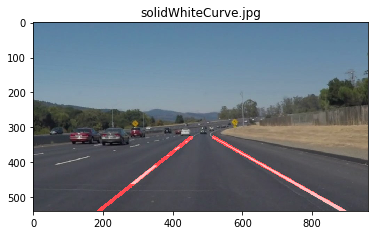

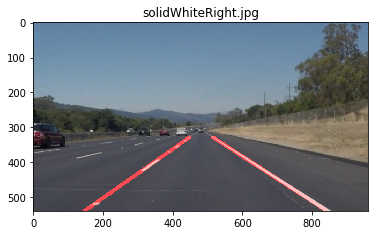

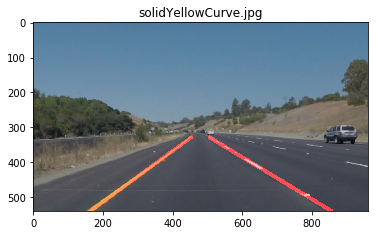

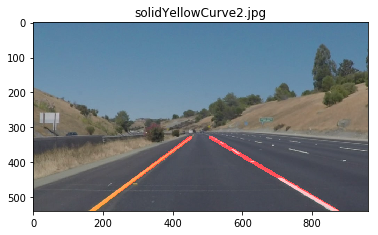

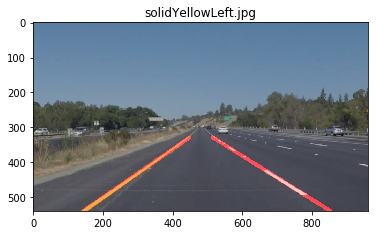

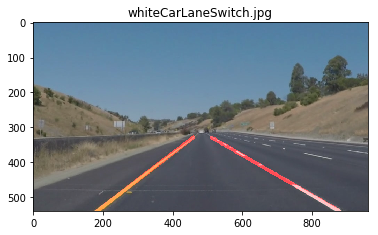

In [14]:
import os
images = os.listdir("test_images/")
for ind_image_name in images:
    ind_image = mpimg.imread("test_images/" + ind_image_name)
    img_processed = draw_lane_lines(ind_image)
    plt.imshow(img_processed)
    plt.title(ind_image_name)
    plt.show()

## Finding Lanes in Videos

### This code snippet reads a video file, and processes it frame by frame using moviepy library and uses the above defined helper functions to determine lanes

Note that Lane finding in images exactly similar to Lane finding in Images except that video is a continous stream of images(a.k.a. frames)

In [16]:
def process_image(image):
    """
    This is kind of a helper function for VideoClipFile.fl_image function that will be used later
    This should always return a color image since the function that uses this as an argument takes only color images
    """
    result = draw_lane_lines(image)
    return result

### Processing video 'solidWhiteRight.mp4'

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vid_white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(vid_white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 22.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_white_output))

### Processing video 'solidYellowLeft.mp4'

Processed video is embedded below

In [27]:
vid_yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(vid_yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_yellow_output))

OSError: [WinError 6] The handle is invalid

## Optional Challenge

### Processing video 'challenge.mp4'

Processed video is embedded below

In [28]:
vid_challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(vid_challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_challenge_output))

OSError: [WinError 6] The handle is invalid